# Este Script procesa los datos de las transaccion de Credibanco y exporta bases para el Dashboard de seguimiento economico interno, contiene:
> 1. Libreria , autenticacion y funciones
> 2. Carga y proceso de Bases 
> 3. Exportacion de Bases procesadas

## 1. Librerias

In [7]:
import pandas as pd
import geopandas as gpd
from google.cloud import bigquery
import matplotlib as mpl
import pygeos
import multiprocessing as mp
import numpy as np
import pyproj

In [8]:
# !pip install geopandas

## 2. Autenticacion

In [9]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: insights-295219


## 3. Funciones

In [10]:
def sjoin_propio(data_1, data_2):
    return gpd.sjoin_nearest(data_1,data_2, how='left')

In [11]:
def parallelize():
    cpus = mp.cpu_count()
    
    intersection_chunks = np.array_split(final, cpus)
    
    pool = mp.Pool(processes=cpus)
    
    chunk_processes = [pool.apply_async(sjoin_propio, args=(chunk, localidades)) for chunk in intersection_chunks]
    
    intersection_results = [chunk.get() for chunk in chunk_processes]
    
    intersections_dist = gpd.GeoDataFrame(pd.concat(intersection_results), crs=final.crs)

    return intersections_dist

## 3. Cargar Bases

In [12]:
## Base de credibanco segundas variables
query = """
    SELECT ventas,coordinates
    FROM `landing_prod.credibanco_transactions`
    WHERE fecha_autorizacion >= '2021-01-01'
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

credibanco_2= query_job.to_dataframe()

## Base de credibanco primeras variables
query = """
    SELECT fecha_autorizacion, id_mcc, id_lugar
    FROM `landing_prod.credibanco_transactions`
    WHERE fecha_autorizacion >= '2021-01-01'
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

credibanco_1= query_job.to_dataframe()
## Base de administrativos
localidades=gpd.read_file('GE00_BOG_administrativo.geojson', encoding='utf-8')
##
## Base de localidades
query = """
    SELECT *
    FROM `landing_prod.Localidades`

"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

localidades_gr= query_job.to_dataframe()
localidades_gr['geometry']= gpd.GeoSeries.from_wkt(localidades_gr['geometry'])
localidades_gr = gpd.GeoDataFrame(localidades_gr, geometry='geometry', crs= localidades.crs)

In [13]:
## Base de localidades
query = """
    SELECT *
    FROM `landing_prod.Localidades`

"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

localidades_gr= query_job.to_dataframe()
localidades_gr['geometry']= gpd.GeoSeries.from_wkt(localidades_gr['geometry'])
localidades_gr = gpd.GeoDataFrame(localidades_gr, geometry='geometry', crs= localidades.crs)

## 4. Proceso de datos

### 4.1 Union bases credibanco

In [14]:
final = pd.concat([credibanco_1,credibanco_2], axis=1)
final['ventas']=final['ventas'].astype(float)

In [15]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44682311 entries, 0 to 44682310
Data columns (total 5 columns):
 #   Column              Dtype              
---  ------              -----              
 0   fecha_autorizacion  datetime64[ns, UTC]
 1   id_mcc              object             
 2   id_lugar            object             
 3   ventas              float64            
 4   coordinates         object             
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 1.7+ GB


### 4.2 Bases de credibanco en formato geografico

In [16]:
final['coordinates'] = gpd.GeoSeries.from_wkt(final['coordinates'])
final = gpd.GeoDataFrame(final , geometry='coordinates',crs='epsg:4326')

In [17]:
# final.info()

In [18]:
# localidades.info()

### 4.3 Base credibanco con mismo crs que localidades

In [19]:
final = final.to_crs(localidades.crs)

In [20]:
# final.crs

In [21]:
# localidades.crs

### 4.4 Variables de año y mes

In [22]:
final['mes']= pd.DatetimeIndex(final['fecha_autorizacion']).month
final['year']= pd.DatetimeIndex(final['fecha_autorizacion']).year

## 5. Union espacial credibanco y su respectivas variables geograficas

In [23]:
if __name__ == '__main__':
    
    final= parallelize()
    final.info()

/opt/conda/lib/python3.7/site-packages/geopandas/array.py:348: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stacklevel=stacklevel,
/opt/conda/lib/python3.7/site-packages/geopandas/array.py:348: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stacklevel=stacklevel,
/opt/conda/lib/python3.7/site-packages/geopandas/array.py:348: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stacklevel=stacklevel,
/opt/conda/lib/python3.7/site-packages/geopandas/array.py:348: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'G

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 44682311 entries, 0 to 44682310
Data columns (total 14 columns):
 #   Column              Dtype              
---  ------              -----              
 0   fecha_autorizacion  datetime64[ns, UTC]
 1   id_mcc              object             
 2   id_lugar            object             
 3   ventas              float64            
 4   coordinates         geometry           
 5   mes                 int64              
 6   year                int64              
 7   index_right         float64            
 8   ID_Localidad        float64            
 9   ID_UPZ              float64            
 10  ID_Barrio           object             
 11  ID_estrato          object             
 12  Nombre_Loc          object             
 13  Nombre_UPZ          object             
dtypes: datetime64[ns, UTC](1), float64(4), geometry(1), int64(2), object(6)
memory usage: 5.0+ GB


In [24]:
# final = gpd.sjoin_nearest(final,localidades, how='left')
final.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 44682311 entries, 0 to 44682310
Data columns (total 14 columns):
 #   Column              Dtype              
---  ------              -----              
 0   fecha_autorizacion  datetime64[ns, UTC]
 1   id_mcc              object             
 2   id_lugar            object             
 3   ventas              float64            
 4   coordinates         geometry           
 5   mes                 int64              
 6   year                int64              
 7   index_right         float64            
 8   ID_Localidad        float64            
 9   ID_UPZ              float64            
 10  ID_Barrio           object             
 11  ID_estrato          object             
 12  Nombre_Loc          object             
 13  Nombre_UPZ          object             
dtypes: datetime64[ns, UTC](1), float64(4), geometry(1), int64(2), object(6)
memory usage: 5.0+ GB


## 6 .Creacion de Variables colapsadas

In [25]:
ventas = final.groupby(['year','mes','Nombre_Loc','ID_estrato','id_mcc','ID_Barrio'], dropna=False).agg(ventas_sum= ('ventas','sum'),
                                                                                        ventas_count= ('ventas','count'),
                                                                                        comercios= ('id_lugar','nunique')).reset_index()
# numero = final.groupby(['mes','Nombre_Loc','Nombre_UPZ','ID_estrato'], dropna=False).count().reset_index()[['ventas']]
# promedio = final.groupby(['mes','Nombre_Loc','Nombre_UPZ','ID_estrato'], dropna=False).mean().reset_index()[['ventas']]

In [26]:
# ventas['day']=1
# ventas['month']=ventas['mes']
# pd.to_datetime(ventas[['year','month','day']])

## 7. Bases de mapas

In [27]:
mapa = final.groupby(['year','mes','Nombre_Loc','ID_Barrio','Nombre_UPZ','ID_estrato'], dropna=False).agg(ventas_sum= ('ventas','sum'),
                                                                                    ventas_count= ('ventas','sum')).reset_index()
mapa = pd.merge(mapa,localidades, on = ['Nombre_Loc','ID_Barrio','Nombre_UPZ','ID_estrato'], how='left', validate='many_to_one')
mapa = gpd.GeoDataFrame(mapa,geometry='geometry', crs=localidades.crs)
mapa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6494 entries, 0 to 6493
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          6494 non-null   int64   
 1   mes           6494 non-null   int64   
 2   Nombre_Loc    6488 non-null   object  
 3   ID_Barrio     6488 non-null   object  
 4   Nombre_UPZ    6488 non-null   object  
 5   ID_estrato    6488 non-null   object  
 6   ventas_sum    6494 non-null   float64 
 7   ventas_count  6494 non-null   float64 
 8   ID_Localidad  6488 non-null   float64 
 9   ID_UPZ        6488 non-null   float64 
 10  geometry      6488 non-null   geometry
dtypes: float64(4), geometry(1), int64(2), object(4)
memory usage: 608.8+ KB


In [28]:
mapa

,year,mes,Nombre_Loc,ID_Barrio,Nombre_UPZ,ID_estrato,ventas_sum,ventas_count,ID_Localidad,ID_UPZ,geometry
0,2021,5,ANTONIO NARIÃ‘O,001201,CIUDAD JARDIN,Estrato 3,8.082213e+06,8.082213e+06,15.0,35.0,"POLYGON ((-74.09046 4.58774, -74.08989 4.58845..."
1,2021,5,ANTONIO NARIÃ‘O,001202,CIUDAD JARDIN,Estrato 3,1.993904e+08,1.993904e+08,15.0,35.0,"POLYGON ((-74.08868 4.58499, -74.08880 4.58501..."
2,2021,5,ANTONIO NARIÃ‘O,001204,CIUDAD JARDIN,Estrato 3,6.928177e+08,6.928177e+08,15.0,35.0,"POLYGON ((-74.09460 4.57580, -74.09456 4.57585..."
3,2021,5,ANTONIO NARIÃ‘O,001208,CIUDAD JARDIN,Estrato 2,2.078110e+08,2.078110e+08,15.0,35.0,"POLYGON ((-74.08491 4.58926, -74.08514 4.58941..."
4,2021,5,ANTONIO NARIÃ‘O,001208,CIUDAD JARDIN,Estrato 3,6.270000e+06,6.270000e+06,15.0,35.0,"MULTIPOLYGON (((-74.08514 4.58891, -74.08565 4..."
...,...,...,...,...,...,...,...,...,...,...,...
6489,2021,10,USME,002615,COMUNEROS,Estrato 1,9.447200e+05,9.447200e+05,5.0,58.0,"POLYGON ((-74.11122 4.49548, -74.11128 4.49568..."
6490,2021,10,USME,002616,ALFONSO LOPEZ,Estrato 1,7.686944e+06,7.686944e+06,5.0,59.0,"POLYGON ((-74.10038 4.49647, -74.10069 4.49652..."
6491,2021,10,USME,002627,ALFONSO LOPEZ,Estrato 1,3.130098e+07,3.130098e+07,5.0,59.0,"POLYGON ((-74.10242 4.50348, -74.10249 4.50346..."
6492,2021,10,USME,102602,CIUDAD USME,Rural,1.000000e+02,1.000000e+02,5.0,61.0,"POLYGON ((-74.12164 4.47705, -74.12172 4.47711..."


In [29]:
import sys
mapa_agr= mapa.dissolve(by=['Nombre_UPZ','year','mes'], aggfunc='sum')
mapa_agr=mapa_agr.reset_index()
# mapa_agr= mapa_agr.explode(index_parts=False)
# from shapely.ops import orient # version >=1.7a2
# mapa_agr['geometry'] = mapa_agr['geometry'].apply(orient, args=(-1,))
from shapely import wkt
mapa_agr['geometry'] = mapa_agr['geometry'].centroid
# mapa_agr = pd.DataFrame(mapa_agr)

# mapa_agr.to_file("mapa_agr.geojson", driver='GeoJSON')
# mapa_agr =gpd.read_file('mapa_agr.geojson', encoding='utf-8')
# mapa_agr= mapa_agr.explode()
# mapa_agr=mapa_agr.reset_index(drop=True)
# # mapa_agr['geometry']=mapa_agr['geometry'].to_wkt()
# mapa_agr = gpd.GeoDataFrame(mapa_agr , crs = mapa.crs, geometry='geometry')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [30]:
localidades_gr

,OBJECTID,ID_Localidad,ID_UPZ,Nombre_Localidad,Nombre_UPZ,Shape_Length,Shape_Area,geometry
0,6,1,11,USAQUEN,SAN CRISTOBAL NORTE,10882.846739,2.752775e+06,"POLYGON ((-74.03211 4.73114, -74.03192 4.73104..."
1,7,1,12,USAQUEN,TOBERIN,7146.943914,2.906631e+06,"POLYGON ((-74.04869 4.73778, -74.04712 4.73750..."
2,8,1,10,USAQUEN,LA URIBE,11178.433245,3.452643e+06,"POLYGON ((-74.04668 4.75134, -74.04526 4.75107..."
3,47,1,15,USAQUEN,COUNTRY CLUB,7043.604829,2.856068e+06,"POLYGON ((-74.03262 4.71274, -74.03262 4.71275..."
4,48,1,16,USAQUEN,SANTA BARBARA,8571.615469,4.586983e+06,"POLYGON ((-74.03288 4.70341, -74.03594 4.70418..."
...,...,...,...,...,...,...,...,...
109,81,19,70,CIUDAD BOLIVAR,JERUSALEM,13527.648202,5.374763e+06,"POLYGON ((-74.17852 4.57017, -74.17847 4.56979..."
110,95,19,67,CIUDAD BOLIVAR,LUCERO,13507.416167,5.863865e+06,"POLYGON ((-74.13413 4.55646, -74.13417 4.55645..."
111,96,19,63,CIUDAD BOLIVAR,EL MOCHUELO,10914.649249,3.167350e+06,"POLYGON ((-74.12609 4.54482, -74.12609 4.54482..."
112,101,19,65,CIUDAD BOLIVAR,ARBORIZADORA,15669.900833,3.062642e+06,"POLYGON ((-74.16197 4.59562, -74.16192 4.59521..."


In [31]:
mapa_agr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Nombre_UPZ    696 non-null    object  
 1   year          696 non-null    int64   
 2   mes           696 non-null    int64   
 3   geometry      696 non-null    geometry
 4   ventas_sum    696 non-null    float64 
 5   ventas_count  696 non-null    float64 
 6   ID_Localidad  696 non-null    float64 
 7   ID_UPZ        696 non-null    float64 
dtypes: float64(4), geometry(1), int64(2), object(1)
memory usage: 43.6+ KB


In [32]:
localidades_gr['Nombre_UPZ'].value_counts()

PARQUE ENTRENUBES             2
LA FLORA                      2
SAN CRISTOBAL NORTE           1
SUBA                          1
PARQUE SIMON BOLIVAR - CAN    1
                             ..
TINTAL SUR                    1
BOSA OCCIDENTAL               1
BOSA CENTRAL                  1
TUNJUELITO                    1
SAN FRANCISCO                 1
Name: Nombre_UPZ, Length: 112, dtype: int64

In [33]:
mapa_agr.drop('geometry', axis=1, inplace=True)
mapa_agr=pd.merge(mapa_agr,localidades_gr[['Nombre_UPZ','Nombre_Localidad','geometry']], on ='Nombre_UPZ', how='left', validate='many_to_many')
mapa_agr=mapa_agr.dropna()


<AxesSubplot:>

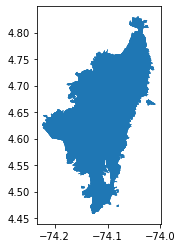

In [34]:
mapa_agr.plot()

In [35]:
mapa_agr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 672 entries, 0 to 701
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Nombre_UPZ        672 non-null    object  
 1   year              672 non-null    int64   
 2   mes               672 non-null    int64   
 3   ventas_sum        672 non-null    float64 
 4   ventas_count      672 non-null    float64 
 5   ID_Localidad      672 non-null    float64 
 6   ID_UPZ            672 non-null    float64 
 7   Nombre_Localidad  672 non-null    object  
 8   geometry          672 non-null    geometry
dtypes: float64(4), geometry(1), int64(2), object(2)
memory usage: 52.5+ KB


In [36]:
mapa_agr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 672 entries, 0 to 701
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Nombre_UPZ        672 non-null    object  
 1   year              672 non-null    int64   
 2   mes               672 non-null    int64   
 3   ventas_sum        672 non-null    float64 
 4   ventas_count      672 non-null    float64 
 5   ID_Localidad      672 non-null    float64 
 6   ID_UPZ            672 non-null    float64 
 7   Nombre_Localidad  672 non-null    object  
 8   geometry          672 non-null    geometry
dtypes: float64(4), geometry(1), int64(2), object(2)
memory usage: 52.5+ KB


In [37]:
# mapa_agr=pd.DataFrame(mapa_agr)

In [38]:
# mapa_agr.to_file("mapa_agr.geojson", driver='GeoJSON')
# mapa_agr =gpd.read_file('mapa_agr.geojson', encoding='utf-8')

In [39]:
ventas = ventas.fillna('NaN')
# mapa['geometry'] = mapa['geometry'].fillna()
# mapa = mapa.fillna('NaN')

# mapa_agr['geometry'] = mapa_agr['geometry'].fillna()
# mapa_agr = mapa_agr.fillna('NaN')

In [40]:
mapa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6494 entries, 0 to 6493
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          6494 non-null   int64   
 1   mes           6494 non-null   int64   
 2   Nombre_Loc    6488 non-null   object  
 3   ID_Barrio     6488 non-null   object  
 4   Nombre_UPZ    6488 non-null   object  
 5   ID_estrato    6488 non-null   object  
 6   ventas_sum    6494 non-null   float64 
 7   ventas_count  6494 non-null   float64 
 8   ID_Localidad  6488 non-null   float64 
 9   ID_UPZ        6488 non-null   float64 
 10  geometry      6488 non-null   geometry
dtypes: float64(4), geometry(1), int64(2), object(4)
memory usage: 608.8+ KB


In [41]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432097 entries, 0 to 432096
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          432097 non-null  int64  
 1   mes           432097 non-null  int64  
 2   Nombre_Loc    432097 non-null  object 
 3   ID_estrato    432097 non-null  object 
 4   id_mcc        432097 non-null  object 
 5   ID_Barrio     432097 non-null  object 
 6   ventas_sum    432097 non-null  float64
 7   ventas_count  432097 non-null  int64  
 8   comercios     432097 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 29.7+ MB


In [43]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432097 entries, 0 to 432096
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          432097 non-null  int64  
 1   mes           432097 non-null  int64  
 2   Nombre_Loc    432097 non-null  object 
 3   ID_estrato    432097 non-null  object 
 4   id_mcc        432097 non-null  object 
 5   ID_Barrio     432097 non-null  object 
 6   ventas_sum    432097 non-null  float64
 7   ventas_count  432097 non-null  int64  
 8   comercios     432097 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 29.7+ MB


In [52]:
ventas[['comercios','ventas_count']]

,comercios,ventas_count
0,20,21
1,69,90
2,1,1
3,1,1
4,1,1
...,...,...
432092,118,4632
432093,246,6418
432094,220,4161
432095,588,5022


## Exportar Base

In [44]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: insights-295219


In [45]:
# Define a name for the new dataset.
dataset_id = 'workzone'

# The project defaults to the Client's project if not specified.
dataset = client.get_dataset(dataset_id)  # API request

## Exportar tabla con informacion de ventas

In [46]:
table_ref = dataset.table("SE_02_map_seguimiento")

job_config = bigquery.job.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

job = client.load_table_from_dataframe(mapa , table_ref, location="US", job_config=job_config)

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Loaded dataframe to /projects/insights-295219/datasets/workzone/tables/SE_02_map_seguimiento


In [47]:
## Exportar mapa con geomtrias de estrato, localidades, etc.

In [48]:
table_ref = dataset.table("SE_01_base_seguimiento")

job_config = bigquery.job.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

job = client.load_table_from_dataframe(ventas , table_ref, location="US")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Loaded dataframe to /projects/insights-295219/datasets/workzone/tables/SE_01_base_seguimiento


In [49]:
table_ref = dataset.table("SE_03_maplocalidades_seguimiento")

job_config = bigquery.job.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

job = client.load_table_from_dataframe(mapa_agr , table_ref, location="US")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Loaded dataframe to /projects/insights-295219/datasets/workzone/tables/SE_03_maplocalidades_seguimiento


In [50]:
mapa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6494 entries, 0 to 6493
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          6494 non-null   int64   
 1   mes           6494 non-null   int64   
 2   Nombre_Loc    6488 non-null   object  
 3   ID_Barrio     6488 non-null   object  
 4   Nombre_UPZ    6488 non-null   object  
 5   ID_estrato    6488 non-null   object  
 6   ventas_sum    6494 non-null   float64 
 7   ventas_count  6494 non-null   float64 
 8   ID_Localidad  6488 non-null   float64 
 9   ID_UPZ        6488 non-null   float64 
 10  geometry      6488 non-null   geometry
dtypes: float64(4), geometry(1), int64(2), object(4)
memory usage: 866.9+ KB


In [ ]:
mapa['Nombre_Loc'].value_counts()

In [ ]:
# client = bigquery.Client(location="us-east4",project='atlas-323415')
# print("Client creating using default project: {}".format(client.project))
# # Define a name for the new dataset.
# dataset_id = 'creditos'

# # The project defaults to the Client's project if not specified.
# dataset = client.get_dataset(dataset_id)  # API reque<zqa12cxst
# table_ref = dataset.table("SE_01_base_seguimiento")
# job_config = bigquery.job.LoadJobConfig()
# job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

# job = client.load_table_from_dataframe(ventas , table_ref, location="US")

# job.result()  # Waits for table load to complete.
# print("Loaded dataframe to {}".format(table_ref.path))